In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [3]:
salary_file = pd.ExcelFile('../contract_data/salaries_1985to2020_final.xlsx')
salaries = pd.read_excel(salary_file, 0)
players_info = pd.read_excel(salary_file, 1)

In [4]:
### add years of the contract
years = list(salaries.groupby('player_id').apply(lambda x: [i for i in range(1, len(x)+1)]))
flatten = lambda l: [item for sublist in l for item in sublist]
salaries['years'] = flatten(years)

In [5]:
salaries_98_20 = salaries.loc[salaries['season_end'] >= 1999]
unique_ids = list(pd.unique(salaries_98_20['player_id']))
filtered_players_info = players_info.loc[[True if pid in unique_ids else False for pid in players_info['_id']]]

In [6]:
# Deal with rookie contracts of first round picks and second round picks
# separately. 
first_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '1st round']
second_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '2nd round']

In [7]:
salaries_first_round = salaries_98_20.loc[[True if pid in list(first_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 4 or less
# Prior to 2011 CBA, first round rookie contract is a 3+1 contract with the fourth year being team option
# After 2011 CBA, first round rookie contract is a 2+2 contract with both the 3rd and 4th year being team options
# Dropping values will potentially over-dropping some datapoints
salaries_first_round = salaries_first_round.loc[salaries_first_round['years'] > 4]

salaries_second_round = salaries_98_20.loc[[True if pid in list(second_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 3 or less
salaries_second_round = salaries_second_round.loc[salaries_second_round['years'] > 3]

In [8]:
# Following part is for fixing data in all stats

In [9]:
stats = pd.read_excel('../season_data/advanced_stats/FINAL_ADVANCED_STATS/all_seasons_advanced_stats.xlsx')

In [10]:
stats['error_in_name'] = stats['Year'].apply(lambda x: x is np.nan)
stats_need_fix = stats.loc[stats['error_in_name'] == True]

In [11]:
stats_need_fix['Year'] = '2019-20'
name = stats_need_fix['name'].apply(lambda x: re.sub(r"\\.+", "", x))
slug = stats_need_fix['name'].apply(lambda x: re.sub(r".+\\", "", x))
stats_need_fix['name'], stats_need_fix['slug'] = name, slug

In [12]:
stats = stats.loc[stats['error_in_name'] == False].append(stats_need_fix).drop(columns=['error_in_name'])

In [13]:
# Create a primary key in two salaries table for joins
salaries_first_round['key'] = salaries_first_round['player_id'] + " " + salaries_first_round['season']
salaries_second_round['key'] = salaries_second_round['player_id'] + " " + salaries_second_round['season']
stats['key'] = stats['slug'] + " " + stats['Year']

In [14]:
salaries_stats_first_round = salaries_first_round.join(stats.set_index('key'), on='key', how='left').dropna()
salaries_stats_second_round = salaries_second_round.join(stats.set_index('key'), on='key', how='left').dropna()

In [15]:
first_round_counts = salaries_stats_first_round[['names', 'key']].groupby('key').count()
second_round_counts = salaries_stats_second_round[['names', 'key']].groupby('key').count()
not_traded_mid_season_first_round = list(first_round_counts.loc[first_round_counts['names'] == 1].index)
not_traded_mid_season_second_round = list(second_round_counts.loc[second_round_counts['names'] == 1].index)

In [16]:
salary_caps_file = pd.ExcelFile('salary_caps.xlsx')
salary_caps = pd.read_excel(salary_caps_file, 0)
salary_caps = salary_caps.drop(columns=salary_caps.columns[0])
salary_caps_99_20 = salary_caps.set_index('season').loc[np.unique(salaries_stats_first_round['season'])]

In [17]:
salaries_stats_first_round = salaries_stats_first_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_first_round = salaries_stats_first_round[salaries_stats_first_round['name'].notna()]
salaries_stats_second_round = salaries_stats_second_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_second_round = salaries_stats_second_round[salaries_stats_second_round['name'].notna()]

In [18]:
salaries_stats_first_round['cap_space_usage'] = salaries_stats_first_round['salary'] / salaries_stats_first_round['salary_cap']
salaries_stats_second_round['cap_space_usage'] = salaries_stats_second_round['salary'] / salaries_stats_second_round['salary_cap']
salaries_stats_first_round['minutes_per_game'] = salaries_stats_first_round['minutes_played'] / salaries_stats_first_round['games_played']
salaries_stats_second_round['minutes_per_game'] = salaries_stats_second_round['minutes_played'] / salaries_stats_second_round['games_played']
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['assist_percentage'] / salaries_stats_first_round['turnover_percentage']
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['assist_percentage'] / salaries_stats_second_round['turnover_percentage']
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting_percentage'] * salaries_stats_first_round['usage_percentage']
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting_percentage'] * salaries_stats_second_round['usage_percentage']

In [19]:
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting*usage'].replace([0], np.nan)
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting*usage'].replace([0], np.nan)

In [20]:
salaries_stats_first_round = salaries_stats_first_round.drop(columns=['names', 'player_id', 'season', 'season_end',
                                        'season_start', 'years', 'name', 'team',
                                        'slug', 'is_combined_totals', 'Year', 'salary', 'salary_cap'])
salaries_stats_second_round = salaries_stats_second_round.drop(columns=['names', 'player_id', 'season', 'season_end',
                                        'season_start', 'years', 'name', 'team',
                                        'slug', 'is_combined_totals', 'Year', 'salary', 'salary_cap'])
salaries_stats_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['minutes_played'] >= 700]
salaries_stats_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['minutes_played'] >= 700]

In [21]:
salaries_stats_first_round.columns

Index(['key', 'positions', 'age', 'games_played', 'minutes_played',
       'player_efficiency_rating', 'true_shooting_percentage',
       'three_point_attempt_rate', 'free_throw_attempt_rate',
       'offensive_rebound_percentage', 'defensive_rebound_percentage',
       'total_rebound_percentage', 'assist_percentage', 'steal_percentage',
       'block_percentage', 'turnover_percentage', 'usage_percentage',
       'offensive_win_shares', 'defensive_win_shares', 'win_shares',
       'win_shares_per_48_minutes', 'offensive_box_plus_minus',
       'defensive_box_plus_minus', 'box_plus_minus',
       'value_over_replacement_player', 'cap_space_usage', 'minutes_per_game',
       'ast/tov_percentage', 'true_shooting*usage'],
      dtype='object')

In [22]:
pg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POINT GUARD"].dropna()
sg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SHOOTING GUARD"].dropna()
sf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SMALL FORWARD"].dropna()
pf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POWER FORWARD"].dropna()
c_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "CENTER"].dropna()

In [23]:
pg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POINT GUARD"].dropna()
sg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SHOOTING GUARD"].dropna()
sf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SMALL FORWARD"].dropna()
pf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POWER FORWARD"].dropna()
c_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "CENTER"].dropna()

In [37]:
def find_percentile_for_feature(data, feature, percentile, position):
    return np.percentile(data.loc[(data['positions'] == position) & (data['minutes_played'] >= 700)][feature], percentile)

In [35]:
types = ['total_rebound_percentage',
        'assist_percentage',
        'three_point_attempt_rate',
        'block_percentage',
        'defensive_box_plus_minus',
        'steal_percentage']

In [41]:
def archtype_rewards_punishments(dataset, data, upper_p, lower_p, archtypes):
    # data: a Series containing data of a player
    # upper_p: upper percentile for specific statline
    # lower_p: lower percentile for specific statline
    # types: archtypes
    # return a list of weights
    pos = data.positions
    weights = []
    position_data = dataset.loc[dataset['positions'] == pos]
    cap_usage_mean = position_data['cap_space_usage'].mean()
    
    for archtype in archtypes:
        upper_value = find_percentile_for_feature(dataset, archtype, upper_p, pos)
        lower_value = find_percentile_for_feature(dataset, archtype, lower_p, pos)
        if data[archtype] >= upper_value:
            upper_mean = position_data.loc[position_data[archtype] >= upper_value]['cap_space_usage'].mean()
            weights.append(upper_mean - cap_usage_mean)
        elif data[archtype] <= lower_value:
            lower_mean = position_data.loc[position_data[archtype] <= lower_value]['cap_space_usage'].mean()
            weights.append(cap_usage_mean - lower_mean)
        else:
            weights.append(0)
                
    return weights

In [49]:
salaries_stats_first_round.iloc[2365]

key                              stackje01 2001-02
positions                            SMALL FORWARD
age                                             27
games_played                                    76
minutes_played                                2685
player_efficiency_rating                        19
true_shooting_percentage                     0.518
three_point_attempt_rate                     0.227
free_throw_attempt_rate                      0.437
offensive_rebound_percentage                   3.4
defensive_rebound_percentage                  10.4
total_rebound_percentage                       6.9
assist_percentage                             28.4
steal_percentage                               1.5
block_percentage                                 1
turnover_percentage                           14.5
usage_percentage                              32.3
offensive_win_shares                           3.2
defensive_win_shares                           2.6
win_shares                     

In [50]:
player = salaries_stats_first_round.iloc[2365]
archtype_rewards_punishments(salaries_stats_first_round,
                            player,
                            85, 15, types)

[0, 0.08306775350082735, 0, 0, -0.023521342410948748, 0]

1.3


0.20366632897256312

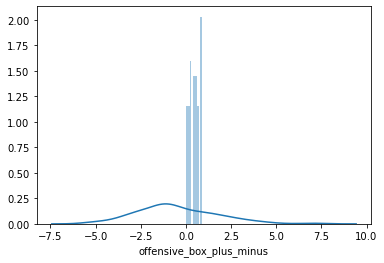

In [57]:
# Example 1
sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & (salaries_stats_first_round['minutes_played'] >= 700)]['offensive_box_plus_minus'], bins=np.arange(0, 1, 0.1))
p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'offensive_box_plus_minus', 80, 'CENTER')
print(p)
c = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['offensive_box_plus_minus'] >= p) &
                                (salaries_stats_first_round['cap_space_usage'] <= 0.3)]
c['cap_space_usage'].mean()

0.1678


0.1420170617566977

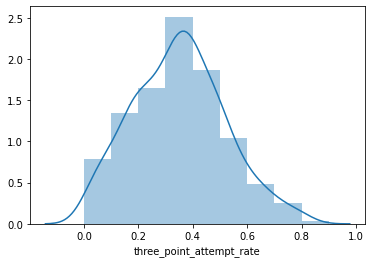

In [63]:
# Example 2
sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SHOOTING GUARD") &
                                                (salaries_stats_first_round['minutes_played'] >= 700)]['three_point_attempt_rate'],
                                                 bins=np.arange(0, 1, 0.1))
p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', 15, 'SHOOTING GUARD')
print(p)
sg = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SHOOTING GUARD") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['three_point_attempt_rate'] <= p)]
sg['cap_space_usage'].mean()

0.126


0.128253101373178

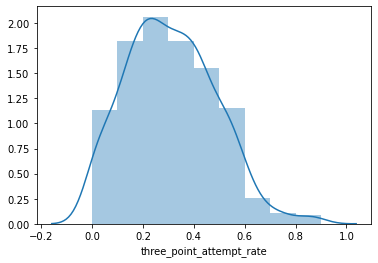

In [64]:
# Example 3
pos = 'SMALL FORWARD'

sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == pos) &
                                                (salaries_stats_first_round['minutes_played'] >= 700)]['three_point_attempt_rate'],
                                                 bins=np.arange(0, 1, 0.1))
p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', 15, pos)
print(p)
sf = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == pos) & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['three_point_attempt_rate'] <= p)]
sf['cap_space_usage'].mean()

22.8


<AxesSubplot:xlabel='cap_space_usage'>

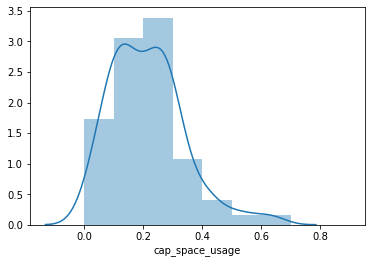

In [46]:
# Example 4

p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'defensive_rebound_percentage', 80, 'POWER FORWARD')
print(p)
pf = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "POWER FORWARD") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['defensive_rebound_percentage'] >= p)]
sns.distplot(pf['cap_space_usage'], bins=np.arange(0, 1, 0.1))

2.5600000000000023


0.1769962435425184

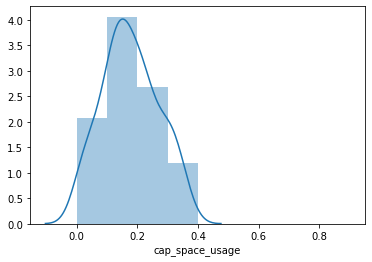

In [66]:
# Example 4

p = find_percentile_for_feature(salaries_stats_first_round, 
                                 'steal_percentage', 80, 'POINT GUARD')
print(p)
pg = salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == 'POINT GUARD') & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['steal_percentage'] >= p)]
sns.distplot(pg['cap_space_usage'], bins=np.arange(0, 1, 0.1))
pg['cap_space_usage'].mean()

In [24]:
def standardize(df, column):
    series = []
    for i in df[column]:
        series.append((i - df[column].mean())/df[column].std())
    return series

def correlation(df, column_1, column_2):
    return np.mean(df[column_1] * df[column_2])

def scatter_and_correlation(df, column_1, column_2, ax, order):
    copy = df.copy()
    copy[column_1 + "_standard"] = standardize(df, column_1)
    copy[column_2 + "_standard"] = standardize(df, column_2)
    copy.plot.scatter(x = column_1 + "_standard", y = column_2 + '_standard', ax=ax[order])
    return correlation(copy, column_1 + '_standard', column_2 + '_standard')

In [25]:
def side_by_side_correlation(filtered_data, unfiltered_data, feature):
    fig, ax = plt.subplots(1,2,figsize=(10, 5))
    corr_filtered = scatter_and_correlation(filtered_data, feature, 'cap_space_usage', ax, 0)
    corr_unfiltered = scatter_and_correlation(unfiltered_data, feature, 'cap_space_usage', ax, 1)
    return (corr_filtered, corr_unfiltered, feature)

In [ ]:
# Blocks below are for visualizations of unified 6 features

# No need to run them

In [ ]:
features = ['player_efficiency_rating',
              'ast/tov_percentage', 'true_shooting*usage', 'offensive_box_plus_minus', 'value_over_replacement_player', 'win_shares']

In [ ]:
correlations = {"C":{}, "PF":{}, "SF":{}, "SG":{}, "PG":{}}

In [ ]:
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(c_first_round.loc[c_first_round["minutes_played"] >= 700], c_first_round, feature)
    print(filtered, unfiltered, feature)
    correlations["C"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(pf_first_round.loc[pf_first_round["minutes_played"] >= 700], pf_first_round, feature)
    correlations["PF"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(sf_first_round.loc[sf_first_round["minutes_played"] >= 700], sf_first_round, feature)
    correlations["SF"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(sg_first_round.loc[sg_first_round["minutes_played"] >= 700], sg_first_round, feature)
    print(filtered, unfiltered, feature)
    correlations["SG"][feature] = filtered

for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(pg_first_round.loc[pg_first_round["minutes_played"] >= 700], pg_first_round, feature)
    correlations["PG"][feature] = filtered

In [ ]:
df = pd.DataFrame.from_dict({(i,j): correlations[i][j] 
                            for i in correlations.keys() 
                            for j in correlations[i].keys()},
                            orient='index')
df.index = pd.MultiIndex.from_tuples(df.index)
df = df.reset_index()
df = df.rename(columns={'level_0': "Position", "level_1": "Feature", 0: "Correlation with cap space usage"})

In [ ]:
for feature in features:
    print(side_by_side_correlation(c_second_round.loc[c_second_round["minutes_played"] >= 350], c_second_round, feature))

for feature in features:
    print(side_by_side_correlation(pf_second_round.loc[pf_second_round["minutes_played"] >= 350], pf_second_round, feature))

for feature in features:
    print(side_by_side_correlation(sf_second_round.loc[sf_second_round["minutes_played"] >= 350], sf_second_round, feature))

for feature in features:
    print(side_by_side_correlation(sg_second_round.loc[sg_second_round["minutes_played"] >= 350], sg_second_round, feature))

for feature in features:
    print(side_by_side_correlation(pg_second_round.loc[pg_second_round["minutes_played"] >= 350], pg_second_round, feature))